<a href="https://colab.research.google.com/github/Ludvins/VC/blob/master/Practica%202/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv1D
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import Resnet
from keras.applications.resnet50 import ResNet50, preprocess_input
# Import Early Stopping
from keras.callbacks import EarlyStopping
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Drive mount

Loads drive path

In [30]:
PATH = "/content/drive/My Drive/VC/"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clean drive folder and unzip data.

In [0]:
!rm -rf "/content/drive/My Drive/VC/images"
!rm -rf "/content/drive/My Drive/VC/lists"
!unzip -q "/content/drive/My Drive/VC/Caltech" -d "/content/drive/My Drive/VC"

# Data reading functions

## Cifar

Loads Cifar data.

In [0]:
def load_cifar_data():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Set labels to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

## Caltech

Returns images and classes in `path_list`.







In [0]:
def read_img (paths_list):
    classes = np.array([path.split('/')[0] for path in path_list])
    vim = np.array([img_to_array(load_img(PATH + "images/"+ im, target_size = (224,224,3))) 
                    for im in path_list])

    return vim, classes

Reads `Caltech` data in `x_train`, `y_train`, `x_test` y `y_test`

In [0]:
def load_caltech_data():

    # Load files with paths
    train_path = np.loadtxt(path + "lists/train.txt", dtype = str)
    test_path = np.loadtxt(path + "lists/test.txt", dtype = str)

    # Read imgs
    print("Loading data...")
    x_train, y_train = read_img(train_path)
    x_test, y_test = read_img(test_path)
    print("Data loaded.")

    # Set classes to numerical
    unique_classes = np.unique(np.copy(y_train))
    for i in range(len(unique_classes)):
      y_train[y_train == unique_classes[i]] = i
      y_test[y_test == unique_classes[i]] = i

    # Set classes to categorical
    y_train = np_utils.to_categorical(y_train, 200)
    y_test = np_utils.to_categorical(y_test, 200)

    # Shuffle data
    x_train_perm = np.random.permutation(len(x_train))
    x_train = x_train[x_train_perm]
    y_train = y_train[x_train_perm]

    x_test_perm = np.random.permutation(len(x_test))
    x_test = x_test[x_test_perm]
    y_test = y_test[x_test_perm]

    return x_train, y_train, x_test, y_test

Preprocess caltech data to be used by ResNet.

In [0]:
def load_preprocessed_caltech_data():
  x_train, y_train, x_test, y_test = load_caltech_data()
  return preprocess_input(x_train), y_train, preprocess_input(x_test), y_test

# Functions for graphics

Draws two graphics.
+ Loss function evolution.
+ Accuracy function evolution.

Args:
+ ```hist```: Training records

In [0]:
def show_evolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

Draws the same graphics as ```show_evolution``` but using a list of records ```hist```.

In [0]:
def compare_evolution(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()

# Data generators

In [0]:
def sample_data_generator():
  return ImageDataGenerator(
      featurewise_center = True,             # set input mean to 0 over the dataset
      samplewise_center = False,             # set each sample mean to 0
      featurewise_std_normalization = True,  # divide inputs by std of the dataset
      samplewise_std_normalization = False,  # divide each input by its std
      zca_whitening = False,                 # apply ZCA whitening
      zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
      rotation_range = 0,                    # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
      height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
      shear_range = 0.,                      # set range for random shear
      zoom_range = 0.,                       # set range for random zoom
      channel_shift_range = 0.,              # set range for random channel shifts
      fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
      cval = 0.,                             # value used for fill_mode = "constant"
      horizontal_flip = True,                # randomly flip images
      vertical_flip = False,                 # randomly flip images
      rescale = None,                        # set rescaling factor (applied before any other transformation)
      preprocessing_function = None,         # set function that will be applied on each input
      data_format = None,                    # image data format, either "channels_first" or "channels_last"
      validation_split = 0.1)                # fraction of images reserved for validation (strictly between 0 and 1)

In [0]:
def train_data_generator():
    return ImageDataGenerator(
        validation_split = 0.1)

In [0]:
def test_data_generator():
    return ImageDataGenerator()

In [0]:
def train_data_generator_with_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      zca_whitening = True,                 
      horizontal_flip = True,             
      validation_split = 0.1)                

In [0]:
def test_data_generator_with_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      zca_whitening = True)   

In [0]:
def train_data_generator_without_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      featurewise_std_normalization = True, 
      width_shift_range = 0.1,               
      height_shift_range = 0.1,              
      horizontal_flip = True,               
      validation_split = 0.1)              

In [0]:
def test_data_generator_without_whitening():
  return ImageDataGenerator(
      featurewise_center = True,             
      featurewise_std_normalization = True)  

# Model definitions

## BaseNet Model

In [0]:
def simple_base_net_model():
    model = Sequential()
    model.name = "Modelo BaseNet"
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

In [0]:
def complex_base_net_model_no_norm():
    model = Sequential()
    model.name = "Modelo BaseNet sin BatchNormalization"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_after_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization despues de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_before_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization antes de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

## ResNet Model

In [0]:
def basic_resnet_model(freeze):
      base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
      if (freeze):
        for layer in base_model.layers:
          layer.trainable = False

      model = Sequential()
      model.name = "ResNet Original"
      model.add(base_model)
      model.add(Dense(200,
                    activation = 'softmax'))
      
      return model

In [0]:
def modified_resnet_model(freeze):

    base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
    if (freeze):
      for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.name = "ResNet Modificado"
    model.add(base_model)
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(200,
                    activation = 'softmax'))

    return model

In [0]:
def modified_resnet_model_dropout(freeze):

    base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
    if (freeze):
      for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.name = "ResNet Modificado"
    model.add(base_model)
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(200,
                    activation = 'softmax'))

    return model

In [0]:
def modified_resnet_model_output_input():
      resnet50 = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))

      x = resnet50.output
      x = Dense(1024, activation='relu')(x)
      last = Dense(200, activation='softmax')(x)
      model = Model(inputs=resnet50.input, output = last)
      
      return model

# Training and evaluation function

In [0]:
def train_and_evaluate(model, train_data_generator, test_data_generator, load_data_function, batch_size, epochs, verbose):

    if (verbose != 0):
      print(" - ENTRENAMIENTO - ")

    model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
        metrics = ['accuracy']
    )

    x_train, y_train, x_test, y_test = load_data_function()
    train_iterator = train_data_generator()
    test_iterator = test_data_generator()
    train_iterator.fit(x_train)
    #datagen.standardize(x_test)  https://github.com/keras-team/keras/issues/2559
    test_iterator.fit(x_train)

    h = model.fit_generator(
                generator = train_iterator.flow(x_train, y_train, batch_size, subset='training'),
                steps_per_epoch = len(x_train)*0.9/batch_size,
                epochs = epochs,
                validation_data = train_iterator.flow(x_train, y_train, batch_size, subset='validation'),
                validation_steps = len(x_train)*0.1/batch_size,
                verbose = verbose,
                callbacks = [EarlyStopping(monitor = 'val_acc', patience = 10, restore_best_weights = True)]
                )
    if (verbose != 0):
      print(" - RESULTADOS - ")

    score = model.evaluate_generator(
        generator = test_iterator.flow(x_test, y_test, 1),
        verbose = verbose
        )
    
    print('PÉRDIDA: ', score[0])
    print('PRECISIÓN: ', score[1])
    return h

# Test functions

## BaseNet & Cifar

--- APARTADO 1. ---
Model: "Modelo BaseNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                20050     
_________________________________________________________________
dense_6 (Dense)              (No

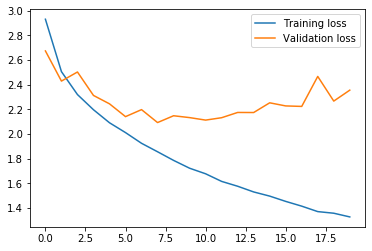

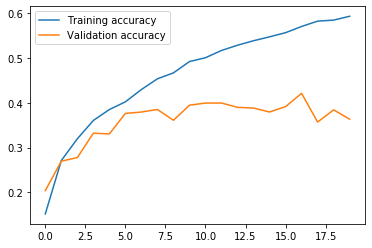

In [55]:
print("--- APARTADO 1. ---")
m = simple_base_net_model()
m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_cifar_data, 32, 20, 1)
print(" - GRÁFICAS - ")
show_evolution(h)

--- COMPARACIÓN DE GENERADORES ---
 - RESULTADOS SIN WHITENING - 
PÉRDIDA:  1.8472548866712517
PRECISIÓN:  0.4552
 - RESULTADOS CON WHITENING - 
PÉRDIDA:  2.0460790401926365
PRECISIÓN:  0.4272
 - GRÁFICAS COMPARATIVAS -


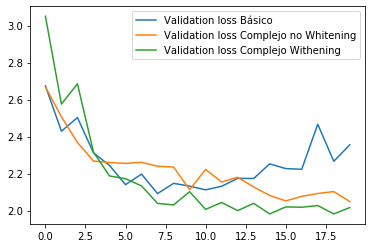

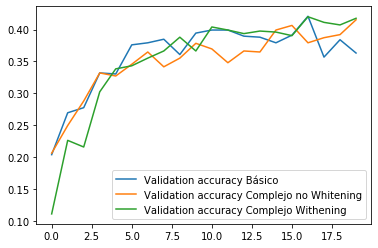

In [56]:
print("--- COMPARACIÓN DE GENERADORES ---")
print(" - RESULTADOS SIN WHITENING - ")
h2 = train_and_evaluate(simple_base_net_model(), train_data_generator_without_whitening, test_data_generator_without_whitening, load_cifar_data, 32, 20, 0)
print(" - RESULTADOS CON WHITENING - ")
h3 = train_and_evaluate(simple_base_net_model(), train_data_generator_with_whitening, test_data_generator_with_whitening, load_cifar_data, 32, 20, 0)
print(" - GRÁFICAS COMPARATIVAS -")
compare_evolution([h, h2, h3], ["Básico", "Complejo no Whitening", "Complejo Withening"])

 --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---
Model: "Modelo BaseNet sin BatchNormalization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        36928     
____________________________________________

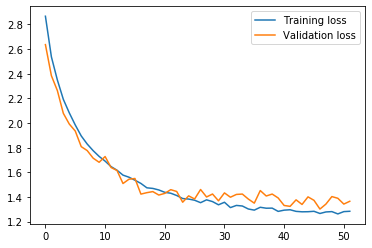

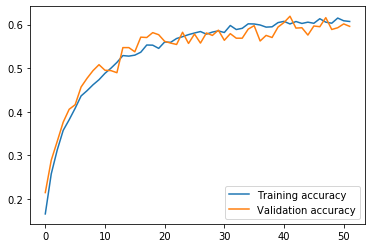

In [57]:
print(" --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---")
m = complex_base_net_model_no_norm()
m.summary()
h = train_and_evaluate(m, train_data_generator_without_whitening, test_data_generator_without_whitening, load_cifar_data, 32, 100, 1)
print(" - GRÁFICAS DE RESULTADOS - ")
show_evolution(h)

 --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- 
 -- BATCHNORMALIZATION ANTES -- 
PÉRDIDA:  1.060947854286859
PRECISIÓN:  0.6768
 - GRÁFICAS RESULTADOS - 


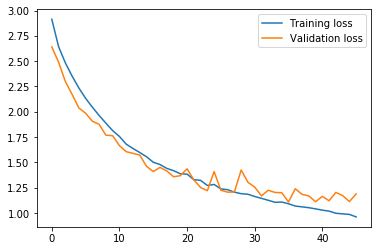

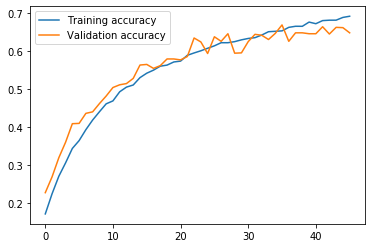

 -- BATCHNORMALIZATION DESPUÉS -- 
PÉRDIDA:  0.9995911995478185
PRECISIÓN:  0.7076
 - GRÁFICAS RESULTADOS - 


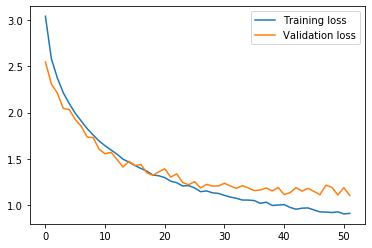

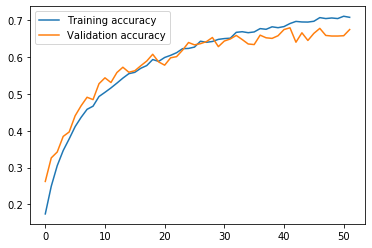

 - GRÁFICAS CONJUNTAS - 


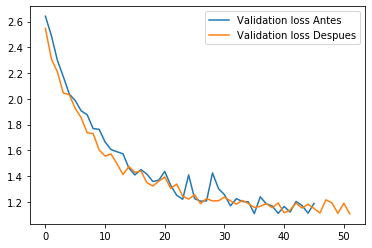

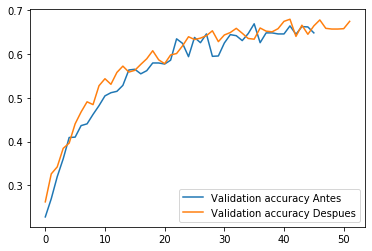

In [60]:
print(" --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- ")
print(" -- BATCHNORMALIZATION ANTES -- ")
m3 = complex_base_net_model_norm_before_relu()
h3 = train_and_evaluate(m3, train_data_generator_without_whitening, test_data_generator_without_whitening, load_cifar_data, 32, 100, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h3)

print(" -- BATCHNORMALIZATION DESPUÉS -- ")
m4 = complex_base_net_model_norm_after_relu()
h4 = train_and_evaluate(m4, train_data_generator_without_whitening, test_data_generator_without_whitening, load_cifar_data, 32, 100, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h4)

print(" - GRÁFICAS CONJUNTAS - ")
compare_evolution([h3, h4], ["Antes", "Después"])

 -- BATCHNORMALIZATION DESPUÉS Y WHITENING -- 
PÉRDIDA:  1.1822255439372287
PRECISIÓN:  0.7
 - GRÁFICAS RESULTADOS - 


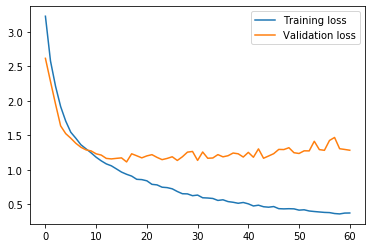

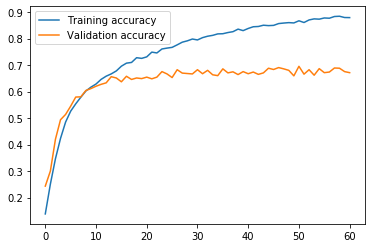

In [61]:
print(" -- BATCHNORMALIZATION DESPUÉS Y WHITENING -- ")
m = complex_base_net_model_norm_after_relu()
h = train_and_evaluate(m, train_data_generator_with_whitening, test_data_generator_with_whitening, load_cifar_data, 32, 100, 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h)

## ResNet & Caltech

 --- RESNET SIN MODIFICAR --- 
Model: "ResNet Original"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_24 (Dense)             (None, 200)               409800    
Total params: 23,997,512
Trainable params: 409,800
Non-trainable params: 23,587,712
_________________________________________________________________
 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/10
85/84 [==============================] - 13s 148ms/step - loss: 4.7616 - acc: 0.0846 - val_loss: 3.6284 - val_acc: 0.2033
Epoch 2/10
85/84 [==============================] - 6s 75ms/step - loss: 2.2146 - acc: 0.5358 - val_loss: 3.0040 - val_acc: 0.3333
Epoch 3/10
85/84 [==============================] - 6s 75ms/step - loss: 1.1861 - acc: 0.7813 - val_loss: 2.7645 - val_acc: 0.3533
Epoch 4/10
85/84 [==

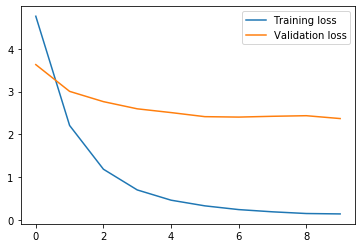

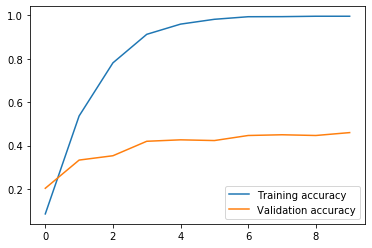

In [71]:
print(" --- RESNET SIN MODIFICAR --- ")
m = basic_resnet_model(freeze = True)
m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_preprocessed_caltech_data, 32, 10, 1)
print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET MODIFICADO PRIMERAS CAPAS CONGELADAS ----
Model: "ResNet Modificado"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_26 (Dense)             (None, 200)               205000    
Total params: 25,890,888
Trainable params: 2,303,176
Non-trainable params: 23,587,712
_________________________________________________________________
 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/10
85/84 [==============================] - 14s 169ms/step - loss: 4.7858 - acc: 0.0752 - val_loss: 3.7873 - val_acc: 0.1800
Epoch 2/10
85/84 [==============================] - 6s 76ms/step - loss: 2.4183 - acc: 0.4423 - val_loss: 3.0647 - val_acc:

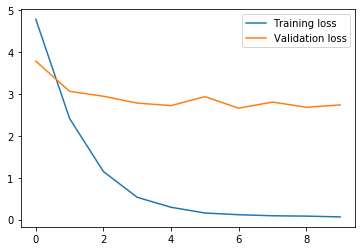

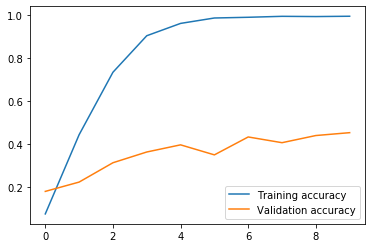

In [72]:
print(" --- RESNET MODIFICADO PRIMERAS CAPAS CONGELADAS ----")
m = modified_resnet_model(freeze = True)
m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_preprocessed_caltech_data, 32, 10, 1)
print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET MODIFICADO CONGELADO MODELO DROPOUT --- 
 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/20
85/84 [==============================] - 34s 397ms/step - loss: 5.4692 - acc: 0.0121 - val_loss: 4.9277 - val_acc: 0.0567
Epoch 2/20
85/84 [==============================] - 7s 83ms/step - loss: 4.7794 - acc: 0.0586 - val_loss: 4.2598 - val_acc: 0.1333
Epoch 3/20
85/84 [==============================] - 7s 83ms/step - loss: 4.2276 - acc: 0.1177 - val_loss: 3.7154 - val_acc: 0.1467
Epoch 4/20
85/84 [==============================] - 7s 82ms/step - loss: 3.8146 - acc: 0.1575 - val_loss: 3.4059 - val_acc: 0.2067
Epoch 5/20
85/84 [==============================] - 7s 82ms/step - loss: 3.4182 - acc: 0.2282 - val_loss: 3.2039 - val_acc: 0.2533
Epoch 6/20
85/84 [==============================] - 7s 82ms/step - loss: 3.1591 - acc: 0.2590 - val_loss: 3.1311 - val_acc: 0.2267
Epoch 7/20
85/84 [==============================] - 7s 82ms/step - loss: 2.8847 - acc: 0.3151 - val_loss: 3.03

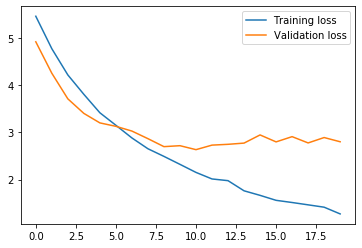

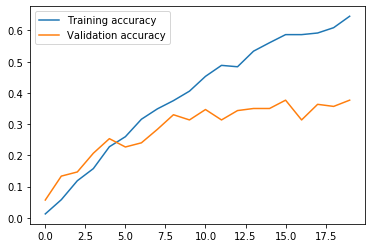

In [83]:
print(" --- RESNET MODIFICADO CONGELADO MODELO DROPOUT --- ")
m = modified_resnet_model_dropout(freeze = True)
#m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_preprocessed_caltech_data, 32, 20, 1)
print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET MODIFICADO SIN CONGELAR --- 
Model: "ResNet Modificado"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_28 (Dense)             (None, 200)               205000    
Total params: 25,890,888
Trainable params: 25,837,768
Non-trainable params: 53,120
_________________________________________________________________
 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/10
85/84 [==============================] - 35s 415ms/step - loss: 4.3867 - acc: 0.1100 - val_loss: 4.1054 - val_acc: 0.1333
Epoch 2/10
85/84 [==============================] - 19s 218ms/step - loss: 1.9702 - acc: 0.4921 - val_loss: 3.5023 - val_acc: 0.2633
Epoch 

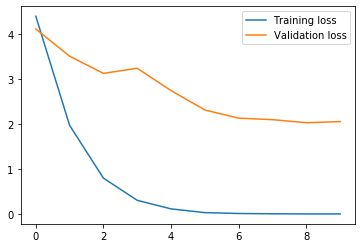

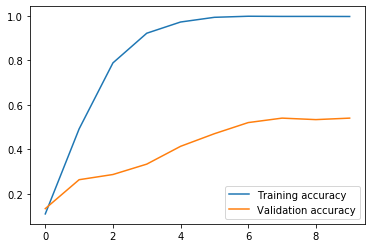

In [73]:
print(" --- RESNET MODIFICADO SIN CONGELAR --- ")
m = modified_resnet_model(freeze = False)
m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_preprocessed_caltech_data, 32, 10, 1)
print(" - GRÁFICAS - ")
show_evolution(h)

 --- RESNET MODIFICADO SIN CONGELAR UTILIZANDO OUTPUT-INPUT --- 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/10
85/84 [==============================] - 36s 426ms/step - loss: 4.4765 - acc: 0.1100 - val_loss: 3.6337 - val_acc: 0.1867
Epoch 2/10
85/84 [==============================] - 19s 219ms/step - loss: 2.0198 - acc: 0.4814 - val_loss: 3.3673 - val_acc: 0.2633
Epoch 3/10
85/84 [==============================] - 19s 219ms/step - loss: 0.7793 - acc: 0.7975 - val_loss: 3.3775 - val_acc: 0.2700
Epoch 4/10
85/84 [==============================] - 19s 219ms/step - loss: 0.3404 - acc: 0.9097 - val_loss: 2.5814 - val_acc: 0.4233
Epoch 5/10
85/84 [==============================] - 19s 219ms/step - loss: 0.1145 - acc: 0.9711 - val_loss: 2.6052 - val_acc: 0.4333
Epoch 6/10
85/84 [==============================] - 19s 219ms/step - loss: 0.0425 - acc: 0.9915 - val_loss: 2.0954 - val_acc: 0.5233
Epoch 7/10
85/84 [==============================] - 19s 219ms/step - loss: 0.0152 - acc: 0.9967 - val_loss: 1.9009 - val_acc: 0.5667
Epoch 8/10
85/84 [==

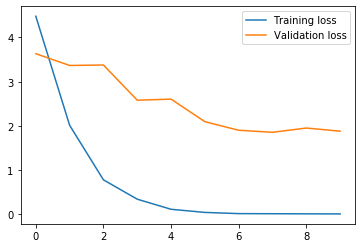

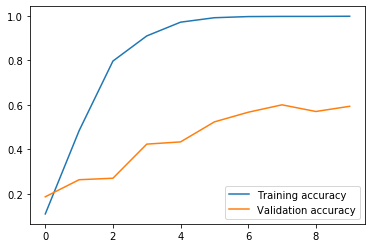

In [74]:
print(" --- RESNET MODIFICADO SIN CONGELAR UTILIZANDO OUTPUT-INPUT --- ")
m = modified_resnet_model_output_input()
#m.summary()
h = train_and_evaluate(m, train_data_generator, test_data_generator, load_preprocessed_caltech_data, 32, 10, 1)
print(" - GRÁFICAS - ")
show_evolution(h)